## MIDS UC Berkeley, Machine Learning at Scale
### SSSP    


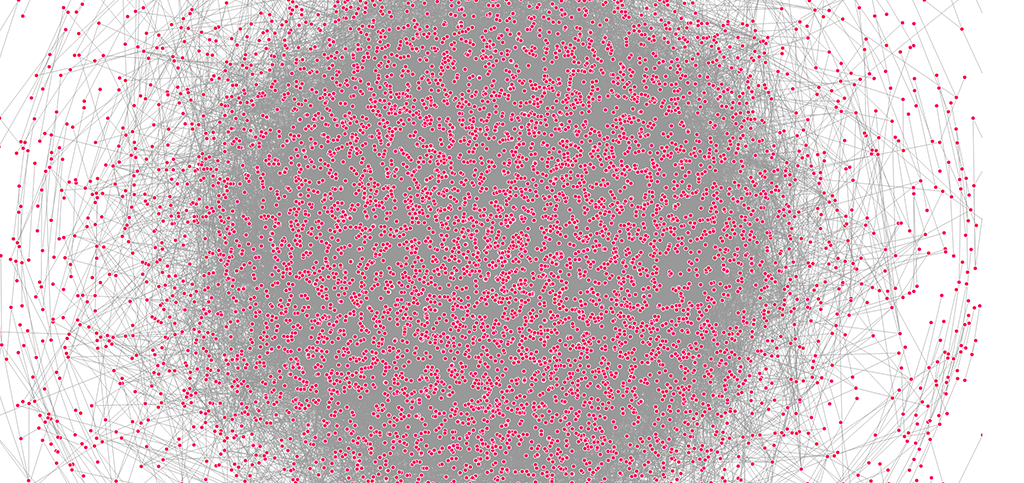

In [1]:
from IPython.display import Image
Image(filename="nltk-pink.png")

<em style="float:right;">nltk synonym graph</em>

<h1 style="color:#021353;">Dataset Description</h1>

Download the dataset from: https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

undirected_toy.txt - Undirected toy network dataset

directed_toy.txt - Directed toy network dataset

synNet/synNet.txt - a sparse representation of the synNet network in indexed form

synNet/indices.txt - the same network in a lookup list of indices and words

wikipedia/all-pages-indexed-out.txt - Graph of Wikipedia

wikipedia/indices.txt - Page titles and page Ids

wikipedia/all-pages-indexed-out.txt - network in indexed format

wikipedia/all-pages-indexed-in.txt - network in indexed format

wikipedia/indices.txt - network in indexed format

<h1 style="color:#021353;">General Description</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
In this assignment you will explore networks and develop Spark code for 
finding shortest path graph distances. To build up to large data 
you will develop your code on some very simple, toy networks.
After this you will take your developed code forward and modify it and 
apply it to two larger datasets (performing EDA along the way).

<h3>Undirected toy network dataset</h3>


In an undirected network all links are symmetric, 
i.e., for a pair of nodes 'A' and 'B,' both of the links:

A -> B and B -> A

will exist. 

The toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)


In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).


<h3>Directed toy network dataset</h3>

In a directed network all links are not necessarily symmetric, 
i.e., for a pair of nodes 'A' and 'B,' it is possible for only one of:

A -> B or B -> A

to exist. 

These toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)


In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).
</pre>
</div>

<h1 style="color:#021353;">Shortest path graph distances (toy networks)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
In this part of your assignment you will develop the base of your code for the week.

Write Spark functions to find shortest path graph distances, as described in the lectures. In addition to finding the distances, your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4. NOTE: There is another shortest path also (HINT: 1->5->4)! Either will suffice (you will find this also in the remaining problems. E.g., 7.2 and 7.4.
 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!

<h3>Main dataset 1: NLTK synonyms</h3>

In the next part of this assignment you will explore a network derived from the NLTK synonym database used for evaluation in HW 5. At a high level, this network is undirected, defined so that there exists link between two nodes/words if the pair or words are a synonym. These data may be found at the location:

synNet/synNet.txt

synNet/indices.txt

where synNet.txt contains a sparse representation of the network:

(index) \t (dictionary of links)

in indexed form, and indices.txt contains a lookup list

(word) \t (index)

of indices and words. This network is small enough for you to explore and run
scripts locally, but will also be good for a systems test (for later) in the cloud.

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).
</pre>
</div>

In [1]:
!cat data/undirected_toy.txt

1	{'2': 1,'5': 1}
2	{'1': 1,'3': 1,'4': 1,'5': 1}
3	{'2': 1, '4': 1}
4	{'2': 1,'3': 1,'5': 1}
5	{'1': 1, '2': 1, '4': 1}


In [8]:
!cat data/directed_toy.txt

1	{'2': 1, '6': 1}
2	{'1': 1, '3': 1, '4': 1}
3	{'2': 1, '4': 1}
4	{'2': 1, '5': 1}
5	{'1': 1, '2': 1, '4': 1}


In [2]:
!cat data/undirected_weighted_toy.txt

1	{"2": 1, "5": 100}
2	{"1": 1, "3": 1, "5": 1, "4": 1}
3	{"2": 1, "4": 1}
4	{"3": 1, "2": 1, "5": 1}
5	{"1": 100, "2": 1, "4": 1, "6":1}
6	{"5": 1, "7": 1}
7	{"6": 1}

In [3]:
!cat data/directed_weighted_toy.txt

1	{"2": 1}
2	{"1": 1, "3": 10}
3	{"4": 1}
4	{"2": 1, "5": 1}
5	{"5":100, "6":1}
6	{"7": 1}

In [4]:
!head data/synNet.txt

1	{'2': 1, '3': 1, '4': 1}
2	{'1': 1, '3': 1, '4': 1, '310': 1, '311': 1}
3	{'1': 1, '2': 1, '4': 1}
4	{'1': 1, '2': 1, '3': 1, '311': 1}
5	{'6': 1}
6	{'5': 1}
7	{'8': 1, '9': 1}
8	{'7': 1, '9': 1}
9	{'7': 1, '8': 1, '124': 1, '1316': 1}
10	{'11': 1, '12': 1, '13': 1, '14': 1, '15': 1, '16': 1, '17': 1}


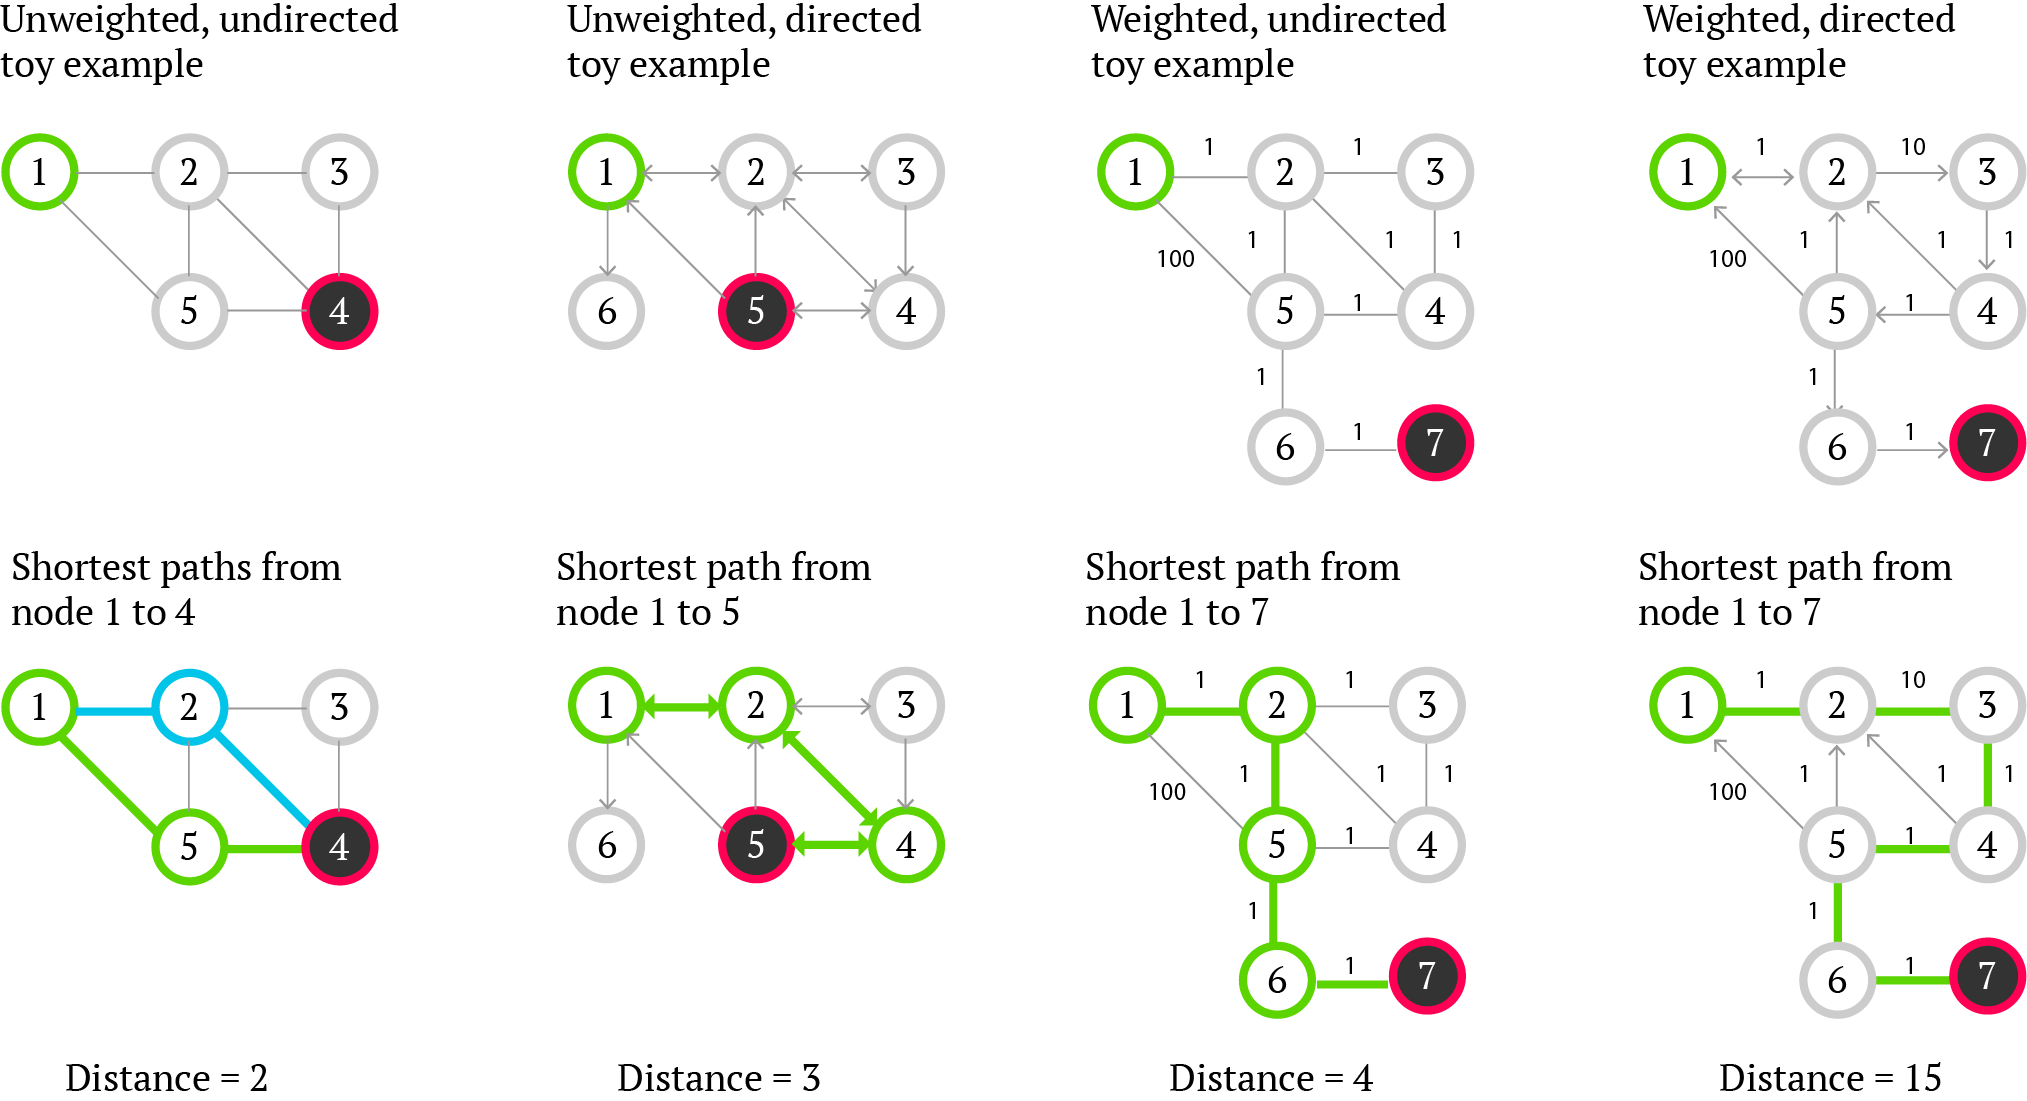

In [15]:
from IPython.display import Image
Image(filename="graphs.png")

# Spark Solution

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
## as a standalone solution

In [3]:
%%writefile sssp.py
from __future__ import print_function
import ast
import sys
from pyspark.accumulators import AccumulatorParam
from pyspark.sql import SparkSession

# Spark only implements Accumulator parameter for numeric types.
# This class extends Accumulator support to the string type.
class StringAccumulatorParam(AccumulatorParam):
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2



###################################
# INITIALIZE GRAPH
###################################

def parseData(line):
    line = line.strip()
    key, value = line.split("\t")
    key = str(key)
  
    if key == startNode.value:
        return (key, ("Q",ast.literal_eval(value),0,key))
    else:
        return (key, ("U",ast.literal_eval(value),float("inf"),""))
    
    
    
###################################
# MAPPER
###################################   

def expandFrontier(row):
  key = row[0]
  status = row[1][0]
  neighbors = row[1][1]
  distance = row[1][2]
  path = row[1][3]
  
  if status == "Q":
    
    # put neighbors in Q mode and update path length by incrementing path length of N
    for neighbor in neighbors:
      yield neighbor, ("Q", {}, distance + int(neighbors[neighbor]), str(path)+" -> "+str(neighbor))
      
    # Update status of current node to Visited
    status = "V"
      
  yield key, (status, neighbors, distance, path)

  
###################################
# REDUCER
###################################

def restoreGraph(a,b):
    
    # It's important that the node in status Q comes first.
    a,b = sorted([a,b]) 
    
    _status, _neighbors, _distance, _path = a # <- Q state (if there is a Q state)
    status, neighbors, distance, path = b # <- V or U state

    if distance > _distance: # if the new path we discovered is shorter than the distance in a visited node, reset the visited node to Q state
        status = "Q" # <- the magic for weighted graphs
        distance = _distance
        path = _path            

    return (status, neighbors, distance, path)  

  
###################################
# ACCUMULATORS
###################################  
  
def terminate(row):
  if row[1][0] == "V" and row[0] == targetNode.value:  
    targetAccum.add(1)
    pathAccum.add(str(row[1][3])+" distance: "+str(row[1][2]))
  if row[1][0] == "Q":
    statusAccum.add(1)

    
    
if __name__ == "__main__":
  
  if len(sys.argv) != 5:
    print("Usage: SSSP <file> <startNode> <targetNode> <isWeighted: 0|1>", file=sys.stderr)
    sys.exit(-1)

    
  
  app_name = "graphs-intro"
  master = "local[*]"
  
  spark = SparkSession \
          .builder \
          .appName(app_name) \
          .master(master) \
          .getOrCreate()
  
  sc = spark.sparkContext
  
  # remember to broadcast global variables:
  dataFile = sc.textFile(sys.argv[1])
  startNode = sc.broadcast(sys.argv[2])
  targetNode = sc.broadcast(sys.argv[3])
  weighted = sys.argv[4]
  
  rdd = dataFile.map(parseData).cache()

  notconverged = True
  iteration = 0
  while notconverged:
    iteration = iteration + 1
    targetAccum = sc.accumulator(0)
    statusAccum = sc.accumulator(0)
    pathAccum = sc.accumulator("", StringAccumulatorParam())

    rdd = rdd.flatMap(expandFrontier).reduceByKey(restoreGraph)

    rdd.foreach(terminate)
  
    if weighted == "1":
      if statusAccum.value == 0: # no more nodes in Q status
        notconverged = False
    else:
      if targetAccum.value == 1: # reached target node
        notconverged = False
        
    print("-"*50)  
    print ("After Iteration "+str(iteration))
    print("Node id, (Status, {out_nodes},distance,path)")
    
    for i in rdd.collect():
      print(i)
      
    print("Num nodes in Q status: ",statusAccum.value)
    #print("Target node in V status: ",targetAccum.value)  # we only care about this in unweighted graphs, where reaching target node terminates the algorithim
    print("-"*50)    
    

  print("Num nodes in Q status: ",statusAccum.value)
  #print("Target node in V status: ",targetAccum.value)
  print("Iterations: ", iteration)
  print("Path: ",pathAccum.value)
  print("="*20)

  spark.stop()

Writing sssp.py


In [2]:
!cat n9-graph.txt

1	{"2": 1, "6": 10}
2	{"3": 1}
3	{"4": 1}
4	{"5": 1}
5	{"6": 1}
6	{"7": 1}
7	{"8": 1}
8	{"9": 1}
9	{}

In [7]:
!python sssp.py "data/undirected_toy2.txt" 1 4 1

2019-10-27 19:19:36 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
--------------------------------------------------
After Iteration 1
Node id, (Status, {out_nodes},distance,path)
('1', ('V', {'2': 1, '3': 100}, 0, '1'))
('4', ('U', {'2': 1, '3': 1}, inf, ''))
('2', ('Q', {'1': 1, '4': 1}, 1, '1 -> 2'))
('3', ('Q', {'1': 100, '4': 1}, 100, '1 -> 3'))
Num nodes in Q status:  2
--------------------------------------------------
--------------------------------------------------
After Iteration 2
Node id, (Status, {out_nodes},distance,path)
('1', ('V', {'2': 1, '3': 100}, 0, '1'))
('4', ('Q', {'2': 1, '3': 1}, 2, '1 -> 2 -> 4'))
('2', ('V', {'1': 1, '4': 1}, 1, '1 -> 2'))
('3', ('V', {'1': 100, '4': 1}, 100, '1 -> 3'))
Num nodes in Q status:  1
----------------------------------

In [3]:
!python sssp.py "data/undirected_weighted_toy.txt" 1 7 1

20/03/05 11:25:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
--------------------------------------------------                              
After Iteration 1
Node id, (Status, {out_nodes},distance,path)
('1', ('V', {'2': 1, '5': 100}, 0, '1'))
('4', ('U', {'3': 1, '2': 1, '5': 1}, inf, ''))
('2', ('Q', {'1': 1, '3': 1, '5': 1, '4': 1}, 1, '1 -> 2'))
('5', ('Q', {'1': 100, '2': 1, '4': 1, '6': 1}, 100, '1 -> 5'))
('3', ('U', {'2': 1, '4': 1}, inf, ''))
('6', ('U', {'5': 1, '7': 1}, inf, ''))
('7', ('U', {'6': 1}, inf, ''))
Num nodes in Q status:  2
--------------------------------------------------
--------------------------------------------------
After Iteration 2
Node id, (Status, {out_nodes},di

In [14]:
!python sssp.py "directed_weighted_toy.txt" 1 7 1

2018-11-06 19:08:27 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
--------------------------------------------------
After Iteration 1
Node id, (Status, {out_nodes},distance,path)
('1', ('V', {'2': 1}, 0, '1'))
('4', ('U', {'2': 1, '5': 1}, inf, '4'))
('2', ('Q', {'1': 1, '3': 10}, 1, '1 -> 2'))
('3', ('U', {'4': 1}, inf, '3'))
('5', ('U', {'5': 100, '6': 1}, inf, '5'))
('6', ('U', {'7': 1}, inf, '6'))
Num nodes in Q status:  1
--------------------------------------------------
--------------------------------------------------
After Iteration 2
Node id, (Status, {out_nodes},distance,path)
('1', ('V', {'2': 1}, 0, '1'))
('4', ('U', {'2': 1, '5': 1}, inf, '4'))
('3', ('Q', {'4': 1}, 11, '1 -> 2 -> 3'))
('2', ('V', {'1': 1, '3': 10}, 1, '1 -> 2'))
('5', ('U', {'5': 100, '6': 1}

### Wikipedia data ~2GB

In [3]:
import time
startNode = "6176135"
targetNode = "13466359"
start = time.time()
!python sssp.py "all-pages-indexed-out.txt" 6176135 13466359 0
end = time.time()
print(end-start)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
18/03/30 13:22:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
18/03/30 13:22:24 WARN Utils: Your hostname, localhost resolves to a loopback address: 127.0.0.1; using 192.168.0.38 instead (on interface en0)
18/03/30 13:22:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
[Stage 0:==============>                                          (16 + 8) / 63]18/03/30 13:24:10 WARN MemoryStore: Not enough space to cache rdd_2_16 in memory! (computed 8.0 MB so far)
18/03/30 13:24:10 WARN BlockManager: Block rdd_2_16 could not be removed as it was not found on disk or in memory
18/03/30 13:24:10 WARN BlockManager: Putting block rdd_2_16 failed
18/03/30 13:24:10 WARN MemoryStore: Not enough 

In [4]:
!python sssp.py undirected_toy.txt 1 4 1 > result.txt

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
18/03/30 13:58:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
18/03/30 13:58:38 WARN Utils: Your hostname, localhost resolves to a loopback address: 127.0.0.1; using 192.168.0.38 instead (on interface en0)
18/03/30 13:58:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


In [5]:
!cat result.txt

Num nodes in Q status:  0
Target node in V status:  1
Iterations:  3
Path:  1 -> 2 -> 4


## Runners
### Stopping criteria

1. For unweighted graphs, we can stop when reached the target node   
2. For weighted graphs, we must iterate until there are no more nodes in the Q state

*In Spark, the behavior of accumulators requires careful attention. It is strongly recommended that accumulators only be used in an action. Accumulators incremented in an action are guaranteed to only be incremented once. Accumulators incremented in a transformation can have their values incremented multiple times if a task or job stage is ever rerun, which is unexpected behavior for most users.*

Transformations https://spark.apache.org/docs/latest/rdd-programming-guide.html#transformations   
Actions https://spark.apache.org/docs/latest/rdd-programming-guide.html#actions

`foreach(func)` : Run a function func on each element of the dataset. This is usually done for side effects such as updating an Accumulator or interacting with external storage systems. 


## NLTK Runner

In [809]:
!head synNet.txt

1	{'2': 1, '3': 1, '4': 1}
2	{'1': 1, '3': 1, '4': 1, '310': 1, '311': 1}
3	{'1': 1, '2': 1, '4': 1}
4	{'1': 1, '2': 1, '3': 1, '311': 1}
5	{'6': 1}
6	{'5': 1}
7	{'8': 1, '9': 1}
8	{'7': 1, '9': 1}
9	{'7': 1, '8': 1, '124': 1, '1316': 1}
10	{'11': 1, '12': 1, '13': 1, '14': 1, '15': 1, '16': 1, '17': 1}


### JOIN NLTK WORDS WITH INDICES

In [811]:
!head indices.txt

A	1
As	2
a	3
as	4
AB	5
abdominal	6
AD	7
ad	8
advertising	9
AIDS	10


In [16]:
!python sssp.py synNet.txt 7827 536 0

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
18/04/05 20:17:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
18/04/05 20:17:37 WARN Utils: Your hostname, localhost resolves to a loopback address: 127.0.0.1; using 192.168.0.38 instead (on interface en0)
18/04/05 20:17:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
18/04/05 20:17:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
18/04/05 20:17:37 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
Num nodes in Q status:  1911
Target node in V status:  1
Iterations:  4
Path:  7827 -> 1426 -> 3992 -> 536 distance: 3


In [22]:
from pyspark.accumulators import AccumulatorParam
from pyspark.sql import SparkSession

app_name = "graphs-intro"
master = "local[*]"

spark = SparkSession \
        .builder \
        .appName(app_name) \
        .master(master) \
        .getOrCreate()

sc = spark.sparkContext
# Takes the path as output by the accumulator: '7827 -> 1426 -> 3992 -> 536'
# and converts to a list: '[7827, 1426, 3992, 536]'
# path = [int(i) for i in pathAccum.value.split("->")]

path = [7827, 1426, 3992, 536]
# Broadcast the path to make available to all tasks
pathbroadcast = sc.broadcast(path)

# Extract the words from the indices.txt file by filtering out by index
def filterIndices(line):
  line = line.strip()
  word, idx = line.split("\t")
  return int(idx) in pathbroadcast.value

# order results to match the indices in the path
def byPathComparator(x):
  # where x is a tuple like: (u'walk', 7827)
  # then x will come first, because 7827 is the first item in the path list
  return pathbroadcast.value.index(x[1])

  
indices = sc.textFile("indices.txt") \
        .filter(filterIndices) \
        .map(lambda line: (line.split('\t')[0], int(line.split('\t')[1])))

numResults = indices.count() 

print "The shortest path is:"
print indices.takeOrdered(numResults, key = byPathComparator)

spark.stop()

The shortest path is:
[(u'walk', 7827), (u'pass', 1426), (u'gave', 3992), (u'make', 536)]


# TODO: 

What do you need to do to create a pipeline? clearly we need the value from the previous job. Can we use external storage to save this value. Is there another way to create a pipeline?

<a name="_7.5"></a>
<h1 style="color:#021353;">Conceptual exercise: Largest single-source network distances</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Suppose you wanted to find the largest network distance from a single source,
i.e., a node that is the furthest (but still reachable) from a single source.

How would you implement this task? 
How is this different from finding the shortest path graph distances?

Is this task more difficult to implement than the shortest path distance?

As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...
</pre>
http://valis.cs.uiuc.edu/~sariel/misc/funny/longestpath.mp3  
    https://sarielhp.org/misc/funny/longestpath.mp3
</div>

In [1]:
%%javascript
$("a").css({"color": "#053597"})

// Remove the right border artifact in Chrome
$(".MathJax").find("nobr > span > span").css({"border-left-color": "#eee"})

<IPython.core.display.Javascript object>